In [14]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from cosinecows.outlier_detection import outlier_detection
from cosinecows.dataset import load_train_data, load_test_data
from cosinecows.config import configs, OutlierDetector
from cosinecows.imputation import imputation

In [15]:
def plot_pca_boundary(x_train, y_train, x_test, outlier_method):
    print(f"Running imputation ({configs['impute_method'].name})...")
    # impute missing values
    imputer = imputation(x_train, i=None)
    x_train = imputer.transform(x_train)
    x_test = imputer.transform(x_test)

    # fit outlier detector on imputed high-dim data
    original_detector_func = outlier_detection(x_train, y_train)
    original_keep_mask = original_detector_func(x_train)

    # normalize and reduce to 2 principal components
    scaler = StandardScaler()
    pca = PCA(n_components=2, random_state=configs['random_state'])
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)

    if outlier_method is OutlierDetector.pca_isoforest:
        detector = IsolationForest(contamination=configs['pca_isoforest_contamination'], random_state=configs["random_state"])
        detector.fit(x_train)
        predict_fn = lambda x: detector.predict(x) # 1 inlier, -1 outlier
    else:
        raise NotImplementedError("Only pca_isoforest is implemented in this function.")

    # create meshgrid to plot the 2D boundary
    xx, yy = np.meshgrid(
        np.linspace(x_train[:, 0].min() - 1, x_train[:, 0].max() + 1, 100),
        np.linspace(x_train[:, 1].min() - 1, x_train[:, 1].max() + 1, 100)
    )
    Z = predict_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plotting w/ 2d training & test data
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    train_df = pd.DataFrame(x_train, columns=['PC1', 'PC2'])
    test_df = pd.DataFrame(x_test, columns=['PC1', 'PC2'])
    train_df['Status'] = np.where(original_keep_mask, 'Inlier (Train)', 'Outlier (Train)')
    test_df['Status'] = 'Test Data'
    full_plot_df = pd.concat([train_df, test_df], ignore_index=True)

    palette = {
        'Inlier (Train)': 'blue', 
        'Outlier (Train)': 'red', 
        'Test Data': 'green'
    }
    markers = {
        'Inlier (Train)': 'o',
        'Outlier (Train)': 'X',
        'Test Data': 'P'
    }
    
    sns.scatterplot(
        data=full_plot_df,
        x='PC1',
        y='PC2',
        hue='Status',
        style='Status',
        palette=palette,
        markers=markers,
        s=70,
        alpha=0.8
    )
    
    plt.title(f"PCA of Data with 2D '{outlier_method.name}' Decision Boundary")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

Loading training and test data...
Running imputation (knn)...
Using PCA+IsolationForest detector (stateful, n_components=2, contamination=0.045)
INFO: OutlierDetector.pca_isoforest (on train data) found 55 outliers. Keeping 1157 / 1212 samples.


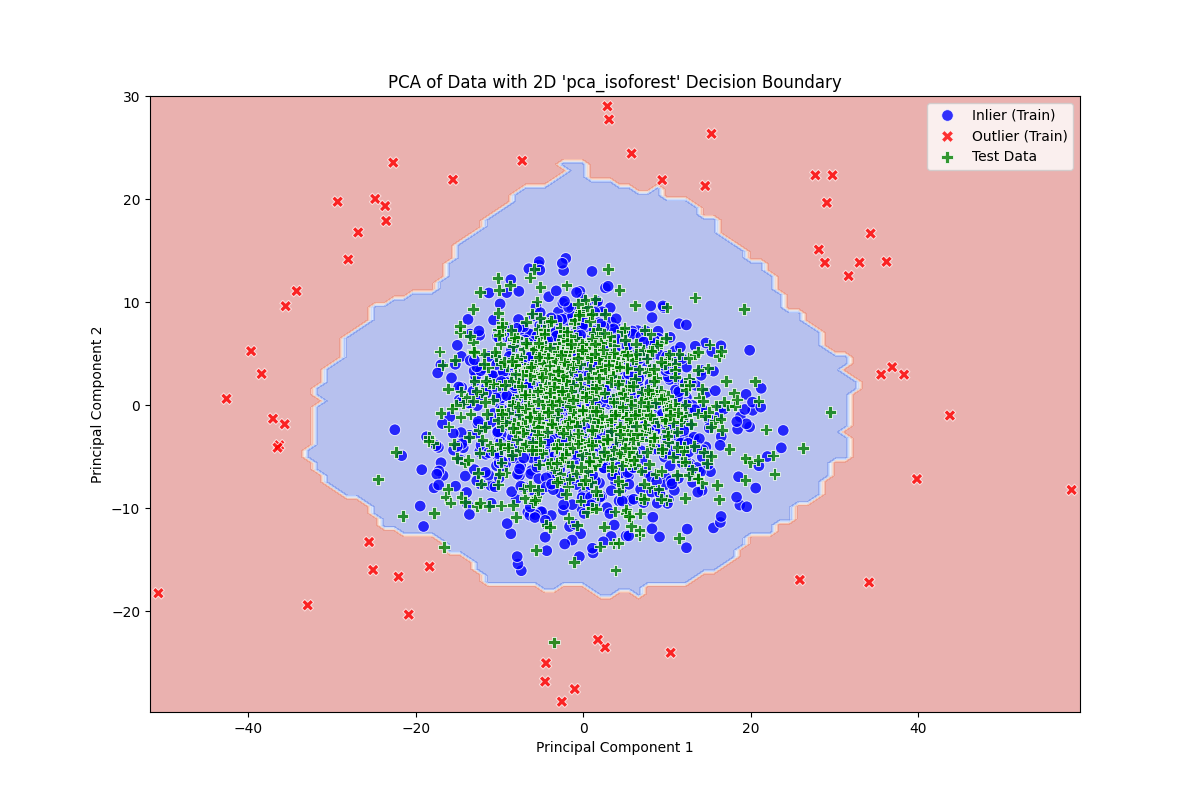

In [16]:
print("Loading training and test data...")
x_train, y_train = load_train_data()
x_test = load_test_data()

plot_pca_boundary(
    x_train.copy(), 
    y_train.copy(), 
    x_test.copy(), 
    OutlierDetector.pca_isoforest
)

## Outlier Detector w.r.t. Brain Age

Plot the outlier detector cluster in 3D with respect to the age to check what has been removed from the dataset.

In [17]:
import plotly.express as px
import pandas as pd
import plotly.io as pio
pio.templates.default = "plotly_white"

In [18]:
def plot_pca_boundary_3D(x, y, outlier_method):
    """
    Plots an interactive 3D scatter plot of the data using:
    - X-axis: PC1
    - Y-axis: PC2
    - Z-axis: Age (y)
    - Color: Outlier Status
    """
    print(f"Running imputation ({configs['impute_method'].name})...")
    # impute missing values
    imputer = imputation(x, i=None)
    x = imputer.transform(x)
    
    # get outliers mask
    configs['outlier_method'] = outlier_method
    original_detector_func = outlier_detection(x, y)
    original_keep_mask = original_detector_func(x)

    # normalize and reduce to 2 principal components
    scaler = StandardScaler()
    pca = PCA(n_components=2, random_state=configs['random_state'])
    x = scaler.fit_transform(x)
    x = pca.fit_transform(x)

    # interactive plot
    plot_df = pd.DataFrame(x, columns=['PC1', 'PC2'])
    plot_df['Age'] = y
    plot_df['Status'] = np.where(original_keep_mask, 'Inlier', 'Outlier')

    fig = px.scatter_3d(
        plot_df,
        x='PC1',
        y='PC2',
        z='Age',
        color='Status',
        color_discrete_map={
            'Inlier': 'blue',
            'Outlier': 'red'
        },
        symbol='Status',
        symbol_map={
            'Inlier': 'circle',
            'Outlier': 'x'
        },
        title=f"3D PCA Plot (Colored by {outlier_method.name} Status)"
    )
    
    fig.update_traces(marker=dict(size=3, opacity=0.8)) # smaller and transparent points
    fig.update_layout(autosize=True) # adjust layout to fit window
    fig.show(renderer="browser")  # renders on dedicated tab in browser

In [19]:
assert np.isnan(x_train).any(), "Training data must contain NaN values to be imputed."

plot_pca_boundary_3D(
    x_train.copy(), 
    y_train.copy(), 
    OutlierDetector.pca_isoforest
)

Running imputation (knn)...
Using PCA+IsolationForest detector (stateful, n_components=2, contamination=0.045)
INFO: OutlierDetector.pca_isoforest (on train data) found 55 outliers. Keeping 1157 / 1212 samples.
